# Yelp Sentiment EDA
266 Summer 2024
Kevin Kuc, 

The data is publically available here:
*   https://huggingface.co/datasets/Yelp/yelp_review_full


**Data Dictionary**

1.   'text': The review texts are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".
2.   'label': Corresponds to the score associated with the review (between 1 and 5).

## Step 1: Import packages

In [32]:
import pandas as pd
import numpy as np
import csv
import copy
from datasets import load_dataset

# data preprocessing
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from numpy.random.mtrand import binomial
import random
import string
from nltk.corpus import stopwords
from contractions import fix

# exploratory analysis
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image
from textblob import TextBlob
from wordcloud import WordCloud

# model fit
import statsmodels.api as sm
#import tensorflow as tf
#from tensorflow import keras
#from keras import metrics
#from tensorflow.keras import initializers


# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# These commands below set some options for pandas and to have matplotlib show the charts in the notebook
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None  # default='warn'

## Step 2: Read data

In [33]:
dataset = load_dataset('yelp_review_full')
df = dataset['train'].to_pandas()
# print shape of df
print(
    'Shape of data: ',
    df.shape
)

Shape of data:  (650000, 2)


In [34]:
df.head(10)

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
5,4,Top notch doctor in a top notch practice. Can'...
6,4,Dr. Eric Goldberg is a fantastic doctor who ha...
7,0,I'm writing this review to give you a heads up...
8,1,Wing sauce is like water. Pretty much a lot of...
9,2,Decent range somewhat close to the city. The ...


In [35]:
df['text'][0]

"dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."

In [36]:
# Randomly sample 50,000 entries
sampled_df = df.sample(n=50000, random_state=42)

In [37]:
# Check null values
print(sampled_df.isnull().sum().sort_values(ascending = False)) # Check nulls

print(sampled_df["label"].value_counts())

label    0
text     0
dtype: int64
label
3    10131
2    10095
0    10049
1     9966
4     9759
Name: count, dtype: int64


## Step 3: Data preprocessing


#### Step 3.1: Create outcome variable

Binary

In [38]:
## define outcome variable with 0 being negative, 1 being mixed, and 2 being positive and ##
#############################

#Remove 3 star food reviews
#sampled_df = sampled_df[sampled_df['label']!=2]

rating_dict = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}

sampled_df["label"] = sampled_df.label.map(rating_dict)
sampled_df["label"].value_counts().sort_index()

label
0    20015
1    10095
2    19890
Name: count, dtype: int64

#### Step 3.2: Undersample the Majority Class to match the Mixed Class

In [48]:
df_negative_class = sampled_df[sampled_df['label'] == 0]
df_mixed_class = sampled_df[sampled_df['label'] == 1]
df_positive_class = sampled_df[sampled_df['label'] == 2]


# Resample the negative and positive class to match mixed class
df_negative_class_downsampled = resample(df_negative_class,
                                  replace=False,
                                  n_samples=len(df_mixed_class),
                                  random_state=1)

df_positive_class_downsampled = resample(df_positive_class,
                                  replace=False,
                                  n_samples=len(df_mixed_class),
                                  random_state=1)

# Combine all classes
df_balanced = pd.concat([df_negative_class_downsampled, df_mixed_class, df_positive_class_downsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

#check the balanced dataset
df_balanced["label"].value_counts().sort_index()

label
0    10095
1    10095
2    10095
Name: count, dtype: int64

##### Data is balanced

#### Step 3.3: Preprocess Text

In [40]:
df_balanced['text']

0        Awesome food! Hands down the best Italian deli...
1        I know it's a good deal on the Strip, but plea...
2        I came here when it first opened & got in w. n...
3        I was very happy with AHR. They were very acco...
4        It is a good place for drinks and late night s...
                               ...                        
30090    Thankfully my sister-in-law directed me to Al'...
30091    DP Dough... \n\nMy first impression of this pl...
30092    Boyfriend and i come here after dinner all the...
30093    I came across these guys while they were worki...
30094    We ate at the deli.  Their eggplant Parmesan s...
Name: text, Length: 30095, dtype: object

In [41]:
def preprocess_review(review):
    """Ensures the input is a string, converts it to lovercase, removes puncuation, 
    keeps alphabetical words only, remove any whitespaces"""
    if isinstance(review, list):
        review = ' '.join(review)
    review = review.lower()
    review = ''.join([char for char in review if char not in string.punctuation])
    review = ' '.join([word for word in review.split() if word.isalpha()])
    review = ' '.join(review.split())
    return review

df_balanced['text'] = df_balanced['text'].apply(preprocess_review)

In [42]:
df_balanced

,label,text
0,1,awesome food hands down the best italian deli ...
1,0,i know its a good deal on the strip but please...
2,1,i came here when it first opened got in w no l...
3,2,i was very happy with ahr they were very accom...
4,0,it is a good place for drinks and late night s...
...,...,...
30090,2,thankfully my sisterinlaw directed me to als b...
30091,1,dp dough nnmy first impression of this place w...
30092,2,boyfriend and i come here after dinner all the...
30093,0,i came across these guys while they were worki...


In [43]:
# Export test as CSV
csv_filename = 'x'
df_balanced.to_csv(csv_filename, index=False)

## Step 4: EDA

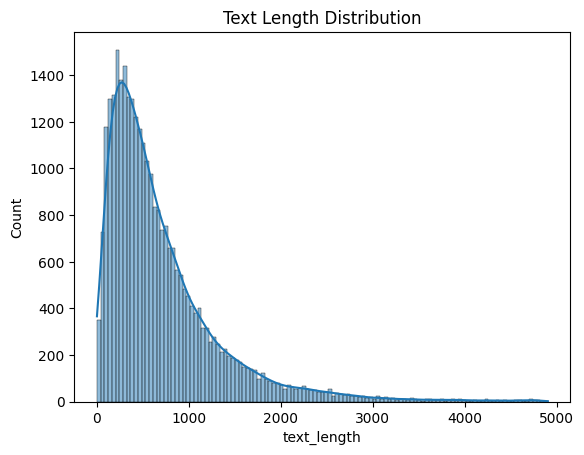

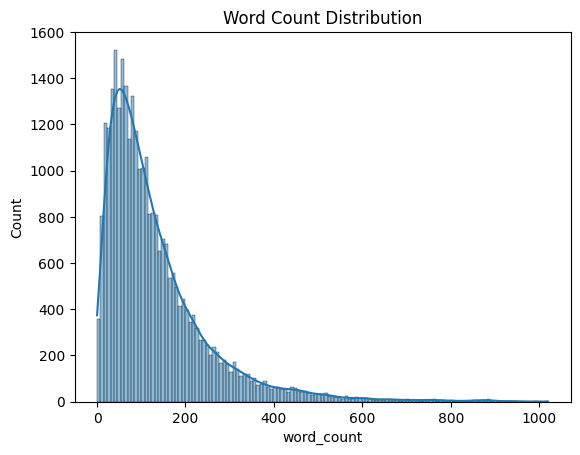

In [44]:
#Analyze text length and word count
df_balanced['text_length'] = df_balanced['text'].apply(len)
df_balanced['word_count'] = df_balanced['text'].apply(lambda x: len(x.split()))

sns.histplot(df_balanced['text_length'], kde=True)
plt.title('Text Length Distribution')
plt.show()

sns.histplot(df_balanced['word_count'], kde=True)
plt.title('Word Count Distribution')
plt.show()

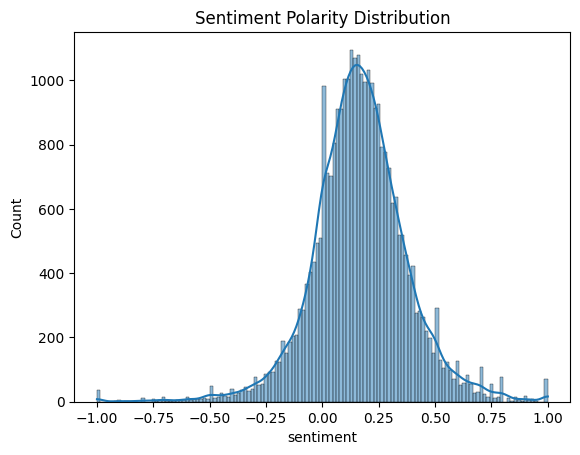

In [45]:
df_balanced['sentiment'] = df_balanced['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sns.histplot(df_balanced['sentiment'], kde=True)
plt.title('Sentiment Polarity Distribution')
plt.show()